In [13]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks in images from prompts with SAM 2

## Set-up

In [14]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2

In [15]:
image_name = 'statue.jpg'

image = Image.open(f'data/image/{image_name}')
image = np.array(image.convert("RGB"))

In [16]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [17]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

## Selecting objects with SAM 2

First, load the SAM 2 model and predictor. Change the path below to point to the SAM 2 checkpoint. Running on CUDA and using the default model are recommended for best results.

In [18]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = os.path.abspath("./model/sam2.1_hiera_small.pt")
model_cfg = os.path.abspath("./model/sam2.1_hiera_s.yaml")

sam2_model = build_sam2(
    config_file=model_cfg,
    ckpt_path=sam2_checkpoint,
    device=device
)

predictor = SAM2ImagePredictor(sam2_model)

predictor.set_image(image)

In [19]:
H, W, _ = image.shape
input_point = np.array([[W//2, H//2+100]])
input_label = np.array([1])


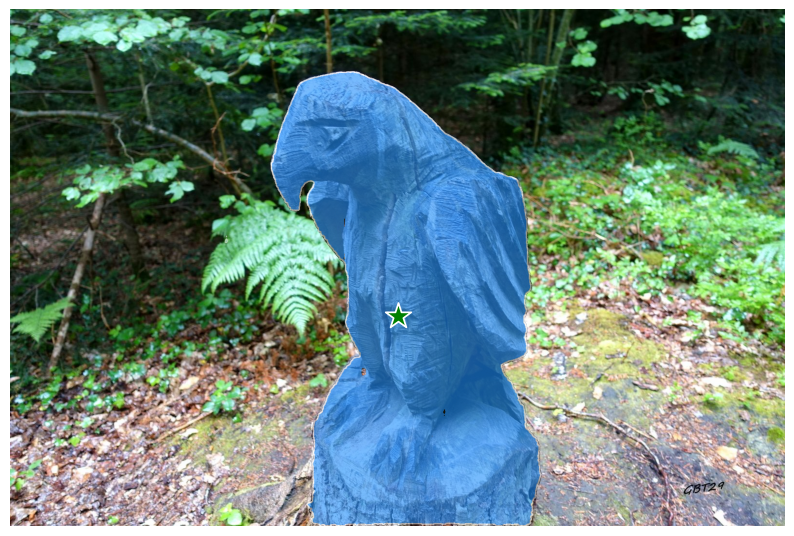

In [20]:
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

# garder la composante connexe la plus grande du masque


show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)

In [21]:
# Convertir le masque en format uint8
mask = masks[0].astype(np.uint8)

# Composer l'image RGBA
image_np = np.array(image).astype(np.uint8)
alpha = (mask * 255).astype(np.uint8)[:, :, None]
image_rgba = np.concatenate((image_np, alpha), axis=2)

# Si le path ne fini pas par .png, remplacer l'extantion par png
if not image_name.lower().endswith('.png'):
    image_name = os.path.splitext(image_name)[0] + '.png'
out_path = './data/export/segmented_' + image_name

os.makedirs(os.path.dirname(out_path), exist_ok=True)

Image.fromarray(image_rgba, mode='RGBA').save(out_path)
